In [3]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 22
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17             

In [5]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
22
(19, 243)
(2, 243)


[I 2025-06-04 21:52:10,476] A new study created in memory with name: no-name-551bb93e-1ed8-4f2a-9aba-114e910a27d4
[I 2025-06-04 21:54:06,523] Trial 0 finished with value: 0.145901620388031 and parameters: {'lr': 0.0029612190414895195, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4715130225082077}. Best is trial 0 with value: 0.145901620388031.


Cross Validation Accuracies:
[0.10739493370056152, 0.23355744779109955, 0.08108788728713989, 0.08018581569194794, 0.22728201746940613]
Mean Cross Validation Accuracy:
0.145901620388031
Standard Deviation of Cross Validation Accuracy:
0.06972584171139572


[I 2025-06-04 21:55:18,650] Trial 1 finished with value: 55.39512329101562 and parameters: {'lr': 0.6519794211326987, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.12131323310431018}. Best is trial 0 with value: 0.145901620388031.


Cross Validation Accuracies:
[80.27105712890625, 73.94331359863281, 9.447895050048828, 61.718048095703125, 51.59530258178711]
Mean Cross Validation Accuracy:
55.39512329101562
Standard Deviation of Cross Validation Accuracy:
25.013649260074818


[I 2025-06-04 21:56:54,802] Trial 2 finished with value: 0.058263928070664404 and parameters: {'lr': 0.33198732426369887, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.16128860406864087}. Best is trial 2 with value: 0.058263928070664404.


Cross Validation Accuracies:
[0.06382479518651962, 0.09937980026006699, 0.02849499322474003, 0.04037652909755707, 0.059243522584438324]
Mean Cross Validation Accuracy:
0.058263928070664404
Standard Deviation of Cross Validation Accuracy:
0.024201431024924606


[I 2025-06-04 21:58:16,467] Trial 3 finished with value: 0.06772527322173119 and parameters: {'lr': 0.015813766945915037, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.25921391595112175}. Best is trial 2 with value: 0.058263928070664404.


Cross Validation Accuracies:
[0.08050847798585892, 0.09943526238203049, 0.05286618322134018, 0.03855995461344719, 0.06725648790597916]
Mean Cross Validation Accuracy:
0.06772527322173119
Standard Deviation of Cross Validation Accuracy:
0.021168664867783318


[I 2025-06-04 22:01:12,040] Trial 4 finished with value: 0.29573916271328926 and parameters: {'lr': 0.2257330774969053, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.43687725671012656}. Best is trial 2 with value: 0.058263928070664404.


Cross Validation Accuracies:
[0.08673248440027237, 0.13057467341423035, 0.017898079007864, 1.1880824565887451, 0.05540812015533447]
Mean Cross Validation Accuracy:
0.29573916271328926
Standard Deviation of Cross Validation Accuracy:
0.44770399418387075


[I 2025-06-04 22:03:42,893] Trial 5 finished with value: 0.07443337924778462 and parameters: {'lr': 0.03612099854929034, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.312784177526501}. Best is trial 2 with value: 0.058263928070664404.


Cross Validation Accuracies:
[0.031224096193909645, 0.05795319750905037, 0.055948901921510696, 0.11540724337100983, 0.11163345724344254]
Mean Cross Validation Accuracy:
0.07443337924778462
Standard Deviation of Cross Validation Accuracy:
0.033295698756051616


[I 2025-06-04 22:05:50,637] Trial 6 finished with value: 0.3725901246070862 and parameters: {'lr': 0.0654370637636399, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3718293261640896}. Best is trial 2 with value: 0.058263928070664404.


Cross Validation Accuracies:
[0.3505750596523285, 0.3907827138900757, 0.4247487485408783, 0.43346166610717773, 0.2633824348449707]
Mean Cross Validation Accuracy:
0.3725901246070862
Standard Deviation of Cross Validation Accuracy:
0.06191578071578251


[I 2025-06-04 22:08:32,816] Trial 7 finished with value: 1.4815911412239076 and parameters: {'lr': 0.024216900347163218, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1016676524957063}. Best is trial 2 with value: 0.058263928070664404.


Cross Validation Accuracies:
[2.0767197608947754, 1.5092910528182983, 1.788649320602417, 0.8840236067771912, 1.1492719650268555]
Mean Cross Validation Accuracy:
1.4815911412239076
Standard Deviation of Cross Validation Accuracy:
0.4281946000757014


[I 2025-06-04 22:10:39,321] Trial 8 finished with value: 0.21725351214408875 and parameters: {'lr': 0.47222432158761296, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.37993896631118307}. Best is trial 2 with value: 0.058263928070664404.


Cross Validation Accuracies:
[0.178020179271698, 0.1528492569923401, 0.25531846284866333, 0.25769156217575073, 0.24238809943199158]
Mean Cross Validation Accuracy:
0.21725351214408875
Standard Deviation of Cross Validation Accuracy:
0.043366084283839736


[I 2025-06-04 22:12:22,183] Trial 9 finished with value: 0.06078990288078785 and parameters: {'lr': 0.6558001933625096, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.135596678887151}. Best is trial 2 with value: 0.058263928070664404.


Cross Validation Accuracies:
[0.078326016664505, 0.11294545233249664, 0.018084654584527016, 0.038587916642427444, 0.05600547417998314]
Mean Cross Validation Accuracy:
0.06078990288078785
Standard Deviation of Cross Validation Accuracy:
0.0327636194832373


[I 2025-06-04 22:14:11,796] Trial 10 finished with value: 0.06876313239336014 and parameters: {'lr': 0.168789094889821, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21625474060799027}. Best is trial 2 with value: 0.058263928070664404.


Cross Validation Accuracies:
[0.02857879549264908, 0.04553937911987305, 0.08961466699838638, 0.09423252195119858, 0.0858502984046936]
Mean Cross Validation Accuracy:
0.06876313239336014
Standard Deviation of Cross Validation Accuracy:
0.026569046615902713


[I 2025-06-04 22:16:03,461] Trial 11 finished with value: 0.13966920599341393 and parameters: {'lr': 0.9820487137097723, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.19267484418097316}. Best is trial 2 with value: 0.058263928070664404.


Cross Validation Accuracies:
[0.08666834235191345, 0.10762183368206024, 0.017791304737329483, 0.4183456599712372, 0.06791888922452927]
Mean Cross Validation Accuracy:
0.13966920599341393
Standard Deviation of Cross Validation Accuracy:
0.1424773823394327


[I 2025-06-04 22:17:50,356] Trial 12 finished with value: 0.06175544410943985 and parameters: {'lr': 0.22426153093672013, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.17149166125376944}. Best is trial 2 with value: 0.058263928070664404.


Cross Validation Accuracies:
[0.07805244624614716, 0.11604008078575134, 0.02282899245619774, 0.03845296800136566, 0.05340273305773735]
Mean Cross Validation Accuracy:
0.06175544410943985
Standard Deviation of Cross Validation Accuracy:
0.032681664188703066


[I 2025-06-04 22:19:39,262] Trial 13 finished with value: 0.0776818111538887 and parameters: {'lr': 0.09368476812056815, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.15998275994672095}. Best is trial 2 with value: 0.058263928070664404.


Cross Validation Accuracies:
[0.07847728580236435, 0.11645474284887314, 0.06958654522895813, 0.06744807958602905, 0.05644240230321884]
Mean Cross Validation Accuracy:
0.0776818111538887
Standard Deviation of Cross Validation Accuracy:
0.020617216556385872


[I 2025-06-04 22:21:16,416] Trial 14 finished with value: 0.06550358831882477 and parameters: {'lr': 0.004265880883004763, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2348705334566335}. Best is trial 2 with value: 0.058263928070664404.


Cross Validation Accuracies:
[0.07851675897836685, 0.037861187011003494, 0.08631855994462967, 0.057102274149656296, 0.06771916151046753]
Mean Cross Validation Accuracy:
0.06550358831882477
Standard Deviation of Cross Validation Accuracy:
0.016983514646837186


[I 2025-06-04 22:23:07,263] Trial 15 finished with value: 3.016662573814392 and parameters: {'lr': 0.3814405966812649, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2800893229658544}. Best is trial 2 with value: 0.058263928070664404.


Cross Validation Accuracies:
[9.247929573059082, 1.360241174697876, 1.33892023563385, 2.2888827323913574, 0.8473391532897949]
Mean Cross Validation Accuracy:
3.016662573814392
Standard Deviation of Cross Validation Accuracy:
3.150329100937514


[I 2025-06-04 22:24:59,530] Trial 16 finished with value: 0.050842386484146115 and parameters: {'lr': 0.0010296097532278019, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14363286981279577}. Best is trial 16 with value: 0.050842386484146115.


Cross Validation Accuracies:
[0.03428604081273079, 0.07109196484088898, 0.040245432406663895, 0.04741588607430458, 0.06117260828614235]
Mean Cross Validation Accuracy:
0.050842386484146115
Standard Deviation of Cross Validation Accuracy:
0.013527067892744618


[I 2025-06-04 22:26:55,989] Trial 17 finished with value: 0.0859168965369463 and parameters: {'lr': 0.001085133654594597, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.32651699822700664}. Best is trial 16 with value: 0.050842386484146115.


Cross Validation Accuracies:
[0.029680557548999786, 0.04256175085902214, 0.017912616953253746, 0.10251761972904205, 0.23691193759441376]
Mean Cross Validation Accuracy:
0.0859168965369463
Standard Deviation of Cross Validation Accuracy:
0.08092201549104563


[I 2025-06-04 22:29:02,561] Trial 18 finished with value: 0.05891713835299015 and parameters: {'lr': 0.007784838382587207, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.19597942424109693}. Best is trial 16 with value: 0.050842386484146115.


Cross Validation Accuracies:
[0.04652438685297966, 0.11498473584651947, 0.01892058365046978, 0.0407593697309494, 0.07339661568403244]
Mean Cross Validation Accuracy:
0.05891713835299015
Standard Deviation of Cross Validation Accuracy:
0.03297344383476153


[I 2025-06-04 22:31:00,650] Trial 19 finished with value: 0.06243171878159046 and parameters: {'lr': 0.0014806179919017134, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.15505440212021587}. Best is trial 16 with value: 0.050842386484146115.


Cross Validation Accuracies:
[0.05092620104551315, 0.13871851563453674, 0.02166357822716236, 0.042487066239118576, 0.058363232761621475]
Mean Cross Validation Accuracy:
0.06243171878159046
Standard Deviation of Cross Validation Accuracy:
0.040071025293241753


[I 2025-06-04 22:32:52,357] Trial 20 finished with value: 0.09310299158096313 and parameters: {'lr': 0.012845132091353066, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.10074025834559366}. Best is trial 16 with value: 0.050842386484146115.


Cross Validation Accuracies:
[0.09758704900741577, 0.1886112540960312, 0.04046707972884178, 0.04386386647820473, 0.0949857085943222]
Mean Cross Validation Accuracy:
0.09310299158096313
Standard Deviation of Cross Validation Accuracy:
0.05355466414868579


[I 2025-06-04 22:34:38,842] Trial 21 finished with value: 0.08003206066787243 and parameters: {'lr': 0.007169081308289179, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.20185837949840027}. Best is trial 16 with value: 0.050842386484146115.


Cross Validation Accuracies:
[0.046767134219408035, 0.13801559805870056, 0.02955339290201664, 0.10471800714731216, 0.08110617101192474]
Mean Cross Validation Accuracy:
0.08003206066787243
Standard Deviation of Cross Validation Accuracy:
0.0390571158843249


[I 2025-06-04 22:36:20,748] Trial 22 finished with value: 0.09217189028859138 and parameters: {'lr': 0.002541340489334704, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.18036168019327886}. Best is trial 16 with value: 0.050842386484146115.


Cross Validation Accuracies:
[0.10693191736936569, 0.2160177379846573, 0.039623670279979706, 0.04072585701942444, 0.0575602687895298]
Mean Cross Validation Accuracy:
0.09217189028859138
Standard Deviation of Cross Validation Accuracy:
0.06657571103485464


[I 2025-06-04 22:38:04,437] Trial 23 finished with value: 0.05478769615292549 and parameters: {'lr': 0.006356493375133309, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.24754457830359414}. Best is trial 16 with value: 0.050842386484146115.


Cross Validation Accuracies:
[0.08323393762111664, 0.04306308180093765, 0.03934113681316376, 0.03857884928584099, 0.06972147524356842]
Mean Cross Validation Accuracy:
0.05478769615292549
Standard Deviation of Cross Validation Accuracy:
0.01828111542272504


[I 2025-06-04 22:39:34,059] Trial 24 finished with value: 0.07362253442406655 and parameters: {'lr': 0.0018335820959274034, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.14278197520615954}. Best is trial 16 with value: 0.050842386484146115.


Cross Validation Accuracies:
[0.04592209681868553, 0.1541990041732788, 0.05043870955705643, 0.05013219267129898, 0.06742066890001297]
Mean Cross Validation Accuracy:
0.07362253442406655
Standard Deviation of Cross Validation Accuracy:
0.04095761406107485


[I 2025-06-04 22:41:03,003] Trial 25 finished with value: 0.08074314370751381 and parameters: {'lr': 0.005296389263180074, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.24901006871854592}. Best is trial 16 with value: 0.050842386484146115.


Cross Validation Accuracies:
[0.10335282236337662, 0.16345475614070892, 0.03494677692651749, 0.04356351122260094, 0.05839785188436508]
Mean Cross Validation Accuracy:
0.08074314370751381
Standard Deviation of Cross Validation Accuracy:
0.04760536261585424


[I 2025-06-04 22:43:01,715] Trial 26 finished with value: 0.0664839766919613 and parameters: {'lr': 0.042368113556196664, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2819924071263539}. Best is trial 16 with value: 0.050842386484146115.


Cross Validation Accuracies:
[0.09131168574094772, 0.12313923984766006, 0.018433324992656708, 0.03826526179909706, 0.061270371079444885]
Mean Cross Validation Accuracy:
0.0664839766919613
Standard Deviation of Cross Validation Accuracy:
0.03730570107176141


[I 2025-06-04 22:44:17,194] Trial 27 finished with value: 0.13706776946783067 and parameters: {'lr': 0.012647911713443247, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2247738307370068}. Best is trial 16 with value: 0.050842386484146115.


Cross Validation Accuracies:
[0.07950613647699356, 0.26225194334983826, 0.08374009281396866, 0.11008494347333908, 0.14975573122501373]
Mean Cross Validation Accuracy:
0.13706776946783067
Standard Deviation of Cross Validation Accuracy:
0.06740521842200668


[I 2025-06-04 22:45:32,987] Trial 28 finished with value: 0.14808801114559172 and parameters: {'lr': 0.0010181059035902686, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12448146964606174}. Best is trial 16 with value: 0.050842386484146115.


Cross Validation Accuracies:
[0.10053286701440811, 0.09364525228738785, 0.15048986673355103, 0.17958568036556244, 0.21618638932704926]
Mean Cross Validation Accuracy:
0.14808801114559172
Standard Deviation of Cross Validation Accuracy:
0.04660636633107348


[I 2025-06-04 22:46:47,450] Trial 29 finished with value: 0.04912157841026783 and parameters: {'lr': 0.003047148059884415, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26876821543893603}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.04226979240775108, 0.042018163949251175, 0.018333101645112038, 0.07720516622066498, 0.06578166782855988]
Mean Cross Validation Accuracy:
0.04912157841026783
Standard Deviation of Cross Validation Accuracy:
0.020550339431150897


[I 2025-06-04 22:48:01,956] Trial 30 finished with value: 0.08896645233035087 and parameters: {'lr': 0.0027931576753901684, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3438413987675475}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.05571906641125679, 0.03907465189695358, 0.07704572379589081, 0.10656259953975677, 0.16643022000789642]
Mean Cross Validation Accuracy:
0.08896645233035087
Standard Deviation of Cross Validation Accuracy:
0.044826206373386634


[I 2025-06-04 22:49:15,102] Trial 31 finished with value: 0.05002711080014706 and parameters: {'lr': 0.004111916675987866, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2724272745500904}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.02817835658788681, 0.07937461137771606, 0.02671024389564991, 0.05925584211945534, 0.05661650002002716]
Mean Cross Validation Accuracy:
0.05002711080014706
Standard Deviation of Cross Validation Accuracy:
0.020054474139579233


[I 2025-06-04 22:50:28,709] Trial 32 finished with value: 0.07175076715648174 and parameters: {'lr': 0.0033059520893997016, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.27742586148211656}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.07308651506900787, 0.15442119538784027, 0.025876065716147423, 0.04126622527837753, 0.06410383433103561]
Mean Cross Validation Accuracy:
0.07175076715648174
Standard Deviation of Cross Validation Accuracy:
0.04456109297096876


[I 2025-06-04 22:51:40,233] Trial 33 finished with value: 0.06034306026995182 and parameters: {'lr': 0.0017508546869528941, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4897598639567185}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.0565214529633522, 0.12311796098947525, 0.018275773152709007, 0.051007501780986786, 0.052792612463235855]
Mean Cross Validation Accuracy:
0.06034306026995182
Standard Deviation of Cross Validation Accuracy:
0.03426108989083462


[I 2025-06-04 22:52:56,899] Trial 34 finished with value: 0.05698689520359039 and parameters: {'lr': 0.0068835385707884155, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.25678615964889223}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.02796066179871559, 0.04217053949832916, 0.04425754398107529, 0.04271091893315315, 0.12783481180667877]
Mean Cross Validation Accuracy:
0.05698689520359039
Standard Deviation of Cross Validation Accuracy:
0.03590909018640683


[I 2025-06-04 22:54:09,628] Trial 35 finished with value: 0.06988575905561448 and parameters: {'lr': 0.0023814399554141583, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2914433778092534}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.08320561796426773, 0.10167132318019867, 0.03537130355834961, 0.07646900415420532, 0.052711546421051025]
Mean Cross Validation Accuracy:
0.06988575905561448
Standard Deviation of Cross Validation Accuracy:
0.023312147314147103


[I 2025-06-04 22:55:37,811] Trial 36 finished with value: 0.11117947474122047 and parameters: {'lr': 0.003900159317241977, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.35477208620835426}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.14556509256362915, 0.054772328585386276, 0.09943802654743195, 0.1499706655740738, 0.10615126043558121]
Mean Cross Validation Accuracy:
0.11117947474122047
Standard Deviation of Cross Validation Accuracy:
0.034733378417585836


[I 2025-06-04 22:57:49,858] Trial 37 finished with value: 0.18839596062898636 and parameters: {'lr': 0.01872227087394999, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4268329520206827}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.03111656755208969, 0.4328625202178955, 0.2250642031431198, 0.18176084756851196, 0.07117566466331482]
Mean Cross Validation Accuracy:
0.18839596062898636
Standard Deviation of Cross Validation Accuracy:
0.1411594054709461


[I 2025-06-04 22:59:02,655] Trial 38 finished with value: 0.07085168696939945 and parameters: {'lr': 0.009696956699248133, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.31040389325599876}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.0993579775094986, 0.10839353501796722, 0.028298789635300636, 0.06442596018314362, 0.05378217250108719]
Mean Cross Validation Accuracy:
0.07085168696939945
Standard Deviation of Cross Validation Accuracy:
0.029547948543681264


[I 2025-06-04 23:00:21,933] Trial 39 finished with value: 0.06448287963867187 and parameters: {'lr': 0.001480433778154344, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2443089041130322}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.03226853162050247, 0.06462136656045914, 0.10422198474407196, 0.06497212499380112, 0.05633039027452469]
Mean Cross Validation Accuracy:
0.06448287963867187
Standard Deviation of Cross Validation Accuracy:
0.02316757352547446


[I 2025-06-04 23:02:08,952] Trial 40 finished with value: 0.07402671165764332 and parameters: {'lr': 0.00523258117345977, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.40826281079861637}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.09214179962873459, 0.13757720589637756, 0.021116288378834724, 0.05451267957687378, 0.06478558480739594]
Mean Cross Validation Accuracy:
0.07402671165764332
Standard Deviation of Cross Validation Accuracy:
0.03907052724303097


[I 2025-06-04 23:03:22,966] Trial 41 finished with value: 0.11586055085062981 and parameters: {'lr': 0.00622046070676109, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26416906508452204}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.05205840244889259, 0.21766772866249084, 0.121573306620121, 0.12388906627893448, 0.06411425024271011]
Mean Cross Validation Accuracy:
0.11586055085062981
Standard Deviation of Cross Validation Accuracy:
0.05866888077978437


[I 2025-06-04 23:04:52,461] Trial 42 finished with value: 0.08881948366761208 and parameters: {'lr': 0.009037289989279504, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26307312742878475}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.0300065316259861, 0.07297395914793015, 0.1232156753540039, 0.13570788502693176, 0.08219336718320847]
Mean Cross Validation Accuracy:
0.08881948366761208
Standard Deviation of Cross Validation Accuracy:
0.03777716129986208


[I 2025-06-04 23:06:09,056] Trial 43 finished with value: 0.10175453498959541 and parameters: {'lr': 0.003933355072343259, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3064160726812766}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.07729282230138779, 0.12133791297674179, 0.02068597450852394, 0.1541154533624649, 0.13534051179885864]
Mean Cross Validation Accuracy:
0.10175453498959541
Standard Deviation of Cross Validation Accuracy:
0.04779891042813357


[I 2025-06-04 23:07:15,903] Trial 44 finished with value: 0.07174686715006828 and parameters: {'lr': 0.02419499895447957, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21684152465274786}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.08078709244728088, 0.07768912613391876, 0.05689926818013191, 0.04113525152206421, 0.10222359746694565]
Mean Cross Validation Accuracy:
0.07174686715006828
Standard Deviation of Cross Validation Accuracy:
0.02099232913514794


[I 2025-06-04 23:08:25,265] Trial 45 finished with value: 0.06352255456149578 and parameters: {'lr': 0.0017995707637069082, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.26099929139047884}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.0980236753821373, 0.08569332212209702, 0.020328035578131676, 0.05154107138514519, 0.06202666833996773]
Mean Cross Validation Accuracy:
0.06352255456149578
Standard Deviation of Cross Validation Accuracy:
0.02717877979970346


[I 2025-06-04 23:10:44,005] Trial 46 finished with value: 0.15644217506051064 and parameters: {'lr': 0.002531090696464024, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3363045644115206}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.2170400321483612, 0.2171703279018402, 0.18037275969982147, 0.04366297647356987, 0.12396477907896042]
Mean Cross Validation Accuracy:
0.15644217506051064
Standard Deviation of Cross Validation Accuracy:
0.06588871010422606


[I 2025-06-04 23:11:54,521] Trial 47 finished with value: 0.07201457247138024 and parameters: {'lr': 0.011194297383933625, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2289222415437365}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.045610211789608, 0.1303941011428833, 0.0508696623146534, 0.04318860173225403, 0.09001028537750244]
Mean Cross Validation Accuracy:
0.07201457247138024
Standard Deviation of Cross Validation Accuracy:
0.03378534927600587


[I 2025-06-04 23:13:04,088] Trial 48 finished with value: 0.11338895112276078 and parameters: {'lr': 0.017169935611088056, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.37306196030070626}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.12919479608535767, 0.1418095976114273, 0.07028090208768845, 0.16222922503948212, 0.06343023478984833]
Mean Cross Validation Accuracy:
0.11338895112276078
Standard Deviation of Cross Validation Accuracy:
0.03948951118289105


[I 2025-06-04 23:14:06,746] Trial 49 finished with value: 0.06637745797634124 and parameters: {'lr': 0.00595352904307068, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3227175825382379}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.05656394734978676, 0.12208463996648788, 0.03216538950800896, 0.04562925547361374, 0.0754440575838089]
Mean Cross Validation Accuracy:
0.06637745797634124
Standard Deviation of Cross Validation Accuracy:
0.031249806017058707


[I 2025-06-04 23:15:14,562] Trial 50 finished with value: 0.08388185799121857 and parameters: {'lr': 0.00465781321274959, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.21014516617136642}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.12335598468780518, 0.16533783078193665, 0.01787526160478592, 0.05570746958255768, 0.057132743299007416]
Mean Cross Validation Accuracy:
0.08388185799121857
Standard Deviation of Cross Validation Accuracy:
0.05302728400980188


[I 2025-06-04 23:16:21,817] Trial 51 finished with value: 0.06210603266954422 and parameters: {'lr': 0.08653742322339396, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.16844473225755469}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.08258091658353806, 0.11055587977170944, 0.017755765467882156, 0.038235682994127274, 0.06140191853046417]
Mean Cross Validation Accuracy:
0.06210603266954422
Standard Deviation of Cross Validation Accuracy:
0.032569446193391326


[I 2025-06-04 23:17:30,563] Trial 52 finished with value: 0.06020263396203518 and parameters: {'lr': 0.04763764845016019, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.12088999367394856}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.04524926468729973, 0.11808638274669647, 0.01800236664712429, 0.03897550329566002, 0.08069965243339539]
Mean Cross Validation Accuracy:
0.06020263396203518
Standard Deviation of Cross Validation Accuracy:
0.035286578270002214


[I 2025-06-04 23:18:38,308] Trial 53 finished with value: 0.3125231504440308 and parameters: {'lr': 0.17310466012671177, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.18602454589445327}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.06485500186681747, 0.10382934659719467, 0.01826666295528412, 1.0908739566802979, 0.2847907841205597]
Mean Cross Validation Accuracy:
0.3125231504440308
Standard Deviation of Cross Validation Accuracy:
0.39951935065112615


[I 2025-06-04 23:19:48,239] Trial 54 finished with value: 3.498904585838318 and parameters: {'lr': 0.3547303836007108, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.24272232381187295}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[4.236921787261963, 2.076580047607422, 0.6703283786773682, 1.8057996034622192, 8.704893112182617]
Mean Cross Validation Accuracy:
3.498904585838318
Standard Deviation of Cross Validation Accuracy:
2.8473651279434886


[I 2025-06-04 23:21:50,976] Trial 55 finished with value: 0.1375243730843067 and parameters: {'lr': 0.003313757790687692, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2958611319670108}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.03893740102648735, 0.11774591356515884, 0.0984535664319992, 0.13262003660202026, 0.2998649477958679]
Mean Cross Validation Accuracy:
0.1375243730843067
Standard Deviation of Cross Validation Accuracy:
0.08719589573707388


[I 2025-06-04 23:23:02,026] Trial 56 finished with value: 0.06764321103692054 and parameters: {'lr': 0.03007516081938849, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.15043269391986303}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.08251748979091644, 0.068366639316082, 0.04243690147995949, 0.04589465260505676, 0.09900037199258804]
Mean Cross Validation Accuracy:
0.06764321103692054
Standard Deviation of Cross Validation Accuracy:
0.02150998324254039


[I 2025-06-04 23:24:07,888] Trial 57 finished with value: 0.08031235113739968 and parameters: {'lr': 0.0013781622615341889, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.12272781164000471}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.03218916058540344, 0.1561753898859024, 0.06185869127511978, 0.09800408780574799, 0.05333442613482475]
Mean Cross Validation Accuracy:
0.08031235113739968
Standard Deviation of Cross Validation Accuracy:
0.043479617438887445


[I 2025-06-04 23:25:14,223] Trial 58 finished with value: 0.058687999844551086 and parameters: {'lr': 0.002285636422135233, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.20112887513405425}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.08067040145397186, 0.07744230329990387, 0.027425028383731842, 0.04737534373998642, 0.06052692234516144]
Mean Cross Validation Accuracy:
0.058687999844551086
Standard Deviation of Cross Validation Accuracy:
0.019716394636325966


[I 2025-06-04 23:26:16,482] Trial 59 finished with value: 0.13853837326169013 and parameters: {'lr': 0.8558428645646539, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.17112607506379696}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.4689039885997772, 0.11327246576547623, 0.018267109990119934, 0.038473378866910934, 0.05377492308616638]
Mean Cross Validation Accuracy:
0.13853837326169013
Standard Deviation of Cross Validation Accuracy:
0.16819204989365294


[I 2025-06-04 23:27:24,036] Trial 60 finished with value: 0.08308585323393344 and parameters: {'lr': 0.007567393377956825, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.27786777519988953}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.09394246339797974, 0.1677238941192627, 0.024511920288205147, 0.04019559919834137, 0.0890553891658783]
Mean Cross Validation Accuracy:
0.08308585323393344
Standard Deviation of Cross Validation Accuracy:
0.050174851908843375


[I 2025-06-04 23:28:34,102] Trial 61 finished with value: 0.07140305936336518 and parameters: {'lr': 0.0020412988827124435, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.19851044970491702}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.029520586133003235, 0.19377803802490234, 0.019037526100873947, 0.040837910026311874, 0.07384123653173447]
Mean Cross Validation Accuracy:
0.07140305936336518
Standard Deviation of Cross Validation Accuracy:
0.06389381676198326


[I 2025-06-04 23:29:40,908] Trial 62 finished with value: 0.11007640585303306 and parameters: {'lr': 0.0013544654290939535, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.252631013930993}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.04086975380778313, 0.07381270080804825, 0.0774485394358635, 0.2122662216424942, 0.14598481357097626]
Mean Cross Validation Accuracy:
0.11007640585303306
Standard Deviation of Cross Validation Accuracy:
0.06148392774337153


[I 2025-06-04 23:30:49,915] Trial 63 finished with value: 0.08762001246213913 and parameters: {'lr': 0.003265514702196545, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2340420488730127}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.09211644530296326, 0.15884706377983093, 0.07999901473522186, 0.04443387687206268, 0.06270366162061691]
Mean Cross Validation Accuracy:
0.08762001246213913
Standard Deviation of Cross Validation Accuracy:
0.03908313498306172


[I 2025-06-04 23:31:58,191] Trial 64 finished with value: 0.1357938304543495 and parameters: {'lr': 0.002152070837094374, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.211442423875715}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.07756822556257248, 0.2825815677642822, 0.05808234214782715, 0.19038470089435577, 0.07035231590270996]
Mean Cross Validation Accuracy:
0.1357938304543495
Standard Deviation of Cross Validation Accuracy:
0.08745134792169633


[I 2025-06-04 23:33:07,605] Trial 65 finished with value: 0.26914983093738554 and parameters: {'lr': 0.004469804685383382, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.1339004833775846}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.3448921740055084, 0.16587968170642853, 0.28762784600257874, 0.2735467255115509, 0.2738027274608612]
Mean Cross Validation Accuracy:
0.26914983093738554
Standard Deviation of Cross Validation Accuracy:
0.05793797618891664


[I 2025-06-04 23:34:15,027] Trial 66 finished with value: 0.10725136771798134 and parameters: {'lr': 0.001170353497738242, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.18061410507034842}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.10401362180709839, 0.1992223858833313, 0.1044175773859024, 0.06802678108215332, 0.06057647243142128]
Mean Cross Validation Accuracy:
0.10725136771798134
Standard Deviation of Cross Validation Accuracy:
0.04938480656105414


[I 2025-06-04 23:35:30,932] Trial 67 finished with value: 0.10332423448562622 and parameters: {'lr': 0.0027337150014547684, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.22111839469555375}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.16381298005580902, 0.10921545326709747, 0.048155590891838074, 0.10484586656093597, 0.09059128165245056]
Mean Cross Validation Accuracy:
0.10332423448562622
Standard Deviation of Cross Validation Accuracy:
0.03715270511655478


[I 2025-06-04 23:36:37,069] Trial 68 finished with value: 0.3014591783285141 and parameters: {'lr': 0.0010068764218929068, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.27246593250293155}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.1786738634109497, 0.21897466480731964, 0.33720216155052185, 0.3837137818336487, 0.3887314200401306]
Mean Cross Validation Accuracy:
0.3014591783285141
Standard Deviation of Cross Validation Accuracy:
0.08664843143531223


[I 2025-06-04 23:37:45,323] Trial 69 finished with value: 0.058854267746210095 and parameters: {'lr': 0.006567352748065882, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.28864441302169397}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.04604887589812279, 0.11363019049167633, 0.027736954391002655, 0.04555374011397362, 0.0613015778362751]
Mean Cross Validation Accuracy:
0.058854267746210095
Standard Deviation of Cross Validation Accuracy:
0.029378768951129786


[I 2025-06-04 23:39:39,738] Trial 70 finished with value: 0.10184436626732349 and parameters: {'lr': 0.003600338221962021, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.15562541400554591}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.035142023116350174, 0.2536768615245819, 0.018557289615273476, 0.1492283046245575, 0.052617352455854416]
Mean Cross Validation Accuracy:
0.10184436626732349
Standard Deviation of Cross Validation Accuracy:
0.08843933834912694


[I 2025-06-04 23:40:49,487] Trial 71 finished with value: 0.10425388813018799 and parameters: {'lr': 0.0059173215136985235, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2881067677860366}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.06822966784238815, 0.23661772906780243, 0.069667749106884, 0.08994989842176437, 0.05680439621210098]
Mean Cross Validation Accuracy:
0.10425388813018799
Standard Deviation of Cross Validation Accuracy:
0.06703758684872932


[I 2025-06-04 23:42:00,715] Trial 72 finished with value: 0.10159778073430062 and parameters: {'lr': 0.008814361408419229, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.27045194943624334}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.05867557227611542, 0.15630358457565308, 0.15823829174041748, 0.07939490675926208, 0.05537654832005501]
Mean Cross Validation Accuracy:
0.10159778073430062
Standard Deviation of Cross Validation Accuracy:
0.04620077570459968


[I 2025-06-04 23:43:15,354] Trial 73 finished with value: 0.09973291605710984 and parameters: {'lr': 0.006957432982156082, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2422081060051878}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.12502869963645935, 0.11621002852916718, 0.09257911890745163, 0.05653467774391174, 0.10831205546855927]
Mean Cross Validation Accuracy:
0.09973291605710984
Standard Deviation of Cross Validation Accuracy:
0.02409248074555011


[I 2025-06-04 23:44:39,889] Trial 74 finished with value: 0.127054101228714 and parameters: {'lr': 0.014113748982755827, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3180187633223031}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.08675535023212433, 0.1841079592704773, 0.18429946899414062, 0.09429620951414108, 0.08581151813268661]
Mean Cross Validation Accuracy:
0.127054101228714
Standard Deviation of Cross Validation Accuracy:
0.0467550945030596


[I 2025-06-04 23:45:50,237] Trial 75 finished with value: 0.09552708491683007 and parameters: {'lr': 0.011082310774847146, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.1104242253910512}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.11936500668525696, 0.16449858248233795, 0.04037166014313698, 0.08179210871458054, 0.07160806655883789]
Mean Cross Validation Accuracy:
0.09552708491683007
Standard Deviation of Cross Validation Accuracy:
0.042727517791510766


[I 2025-06-04 23:47:00,217] Trial 76 finished with value: 0.09964662715792656 and parameters: {'lr': 0.004911191616247875, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.29990401253184923}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.08335699886083603, 0.1341870129108429, 0.062333669513463974, 0.15120616555213928, 0.06714928895235062]
Mean Cross Validation Accuracy:
0.09964662715792656
Standard Deviation of Cross Validation Accuracy:
0.036235645533278356


[I 2025-06-04 23:48:11,702] Trial 77 finished with value: 0.06430813893675805 and parameters: {'lr': 0.0018661824795604511, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.25508524102553215}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.03791350871324539, 0.04856792837381363, 0.13214559853076935, 0.038236189633607864, 0.06467746943235397]
Mean Cross Validation Accuracy:
0.06430813893675805
Standard Deviation of Cross Validation Accuracy:
0.03528805634446851


[I 2025-06-04 23:49:26,492] Trial 78 finished with value: 0.11384362652897835 and parameters: {'lr': 0.002881383402013876, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.20262611684560666}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.17859835922718048, 0.03794920817017555, 0.10159990936517715, 0.10739722102880478, 0.14367343485355377]
Mean Cross Validation Accuracy:
0.11384362652897835
Standard Deviation of Cross Validation Accuracy:
0.0469774847419002


[I 2025-06-04 23:50:34,839] Trial 79 finished with value: 0.08268113583326339 and parameters: {'lr': 0.11257482087863183, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14096497292658372}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.06361714750528336, 0.17677053809165955, 0.04501795023679733, 0.06272575259208679, 0.06527429074048996]
Mean Cross Validation Accuracy:
0.08268113583326339
Standard Deviation of Cross Validation Accuracy:
0.04761508667212847


[I 2025-06-04 23:51:52,309] Trial 80 finished with value: 0.12539976239204406 and parameters: {'lr': 0.0022878158553705026, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.18789966112912265}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.11331746727228165, 0.12213164567947388, 0.08200157433748245, 0.1090397983789444, 0.20050832629203796]
Mean Cross Validation Accuracy:
0.12539976239204406
Standard Deviation of Cross Validation Accuracy:
0.03987232113197448


[I 2025-06-04 23:53:04,067] Trial 81 finished with value: 0.06333812773227691 and parameters: {'lr': 0.007686650370266359, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.1612757840944302}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.04361569881439209, 0.09715236723423004, 0.06454695016145706, 0.04576871544122696, 0.06560690701007843]
Mean Cross Validation Accuracy:
0.06333812773227691
Standard Deviation of Cross Validation Accuracy:
0.01922326639697861


[I 2025-06-04 23:54:11,824] Trial 82 finished with value: 0.10832062214612961 and parameters: {'lr': 0.003952023177650468, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2898565290834924}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.056642577052116394, 0.14415884017944336, 0.02059558779001236, 0.18015336990356445, 0.14005273580551147]
Mean Cross Validation Accuracy:
0.10832062214612961
Standard Deviation of Cross Validation Accuracy:
0.05969514311399101


[I 2025-06-04 23:55:13,903] Trial 83 finished with value: 0.07673753313720226 and parameters: {'lr': 0.006164841098078943, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2377292122133235}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.1634918451309204, 0.05900080129504204, 0.02652808465063572, 0.04950316250324249, 0.08516377210617065]
Mean Cross Validation Accuracy:
0.07673753313720226
Standard Deviation of Cross Validation Accuracy:
0.0472749478482194


[I 2025-06-04 23:56:23,061] Trial 84 finished with value: 0.11338092125952244 and parameters: {'lr': 0.01025848441691842, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.22599909586418102}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.23976433277130127, 0.19060249626636505, 0.02208862639963627, 0.03974408656358719, 0.07470506429672241]
Mean Cross Validation Accuracy:
0.11338092125952244
Standard Deviation of Cross Validation Accuracy:
0.08624201619688736


[I 2025-06-04 23:57:30,774] Trial 85 finished with value: 0.05663618817925453 and parameters: {'lr': 0.00818210799271957, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.25526343932987305}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.0591852143406868, 0.10938668251037598, 0.022229410707950592, 0.03925930708646774, 0.05312032625079155]
Mean Cross Validation Accuracy:
0.05663618817925453
Standard Deviation of Cross Validation Accuracy:
0.029282267002819426


[I 2025-06-04 23:58:37,391] Trial 86 finished with value: 0.0911473199725151 and parameters: {'lr': 0.005192472434556964, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.26784087169639315}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.058575160801410675, 0.11069056391716003, 0.07678115367889404, 0.09995798766613007, 0.10973173379898071]
Mean Cross Validation Accuracy:
0.0911473199725151
Standard Deviation of Cross Validation Accuracy:
0.020358187411477838


[I 2025-06-05 00:00:21,811] Trial 87 finished with value: 0.10655534118413926 and parameters: {'lr': 0.2981286710043219, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.30778840683867537}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.08408555388450623, 0.11534858494997025, 0.2232743799686432, 0.03828436881303787, 0.07178381830453873]
Mean Cross Validation Accuracy:
0.10655534118413926
Standard Deviation of Cross Validation Accuracy:
0.06336486560209353


[I 2025-06-05 00:01:30,531] Trial 88 finished with value: 0.06477337703108788 and parameters: {'lr': 0.001637839695745799, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2502782873406788}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.08879715204238892, 0.06468460708856583, 0.05596376582980156, 0.03891689330339432, 0.07550446689128876]
Mean Cross Validation Accuracy:
0.06477337703108788
Standard Deviation of Cross Validation Accuracy:
0.01696156204930622


[I 2025-06-05 00:02:36,708] Trial 89 finished with value: 9.82951636314392 and parameters: {'lr': 0.6112245144942068, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2845299350542155}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[2.911112070083618, 21.958860397338867, 2.3536925315856934, 11.552519798278809, 10.371397018432617]
Mean Cross Validation Accuracy:
9.82951636314392
Standard Deviation of Cross Validation Accuracy:
7.129314442562516


[I 2025-06-05 00:03:45,367] Trial 90 finished with value: 0.06711164675652981 and parameters: {'lr': 0.020195965622873926, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26060035124857067}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.028605012223124504, 0.13626067340373993, 0.07555576413869858, 0.042575981467962265, 0.052560802549123764]
Mean Cross Validation Accuracy:
0.06711164675652981
Standard Deviation of Cross Validation Accuracy:
0.03781369552426867


[I 2025-06-05 00:04:53,427] Trial 91 finished with value: 0.09637770354747772 and parameters: {'lr': 0.008286097832075921, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.17613649629770373}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.04705217108130455, 0.12550495564937592, 0.13566458225250244, 0.04616357758641243, 0.12750323116779327]
Mean Cross Validation Accuracy:
0.09637770354747772
Standard Deviation of Cross Validation Accuracy:
0.040780193040590475


[I 2025-06-05 00:06:01,403] Trial 92 finished with value: 0.150810843706131 and parameters: {'lr': 0.012966105372631436, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.19451955280305777}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.17678940296173096, 0.12182175368070602, 0.035612113773822784, 0.16054585576057434, 0.2592850923538208]
Mean Cross Validation Accuracy:
0.150810843706131
Standard Deviation of Cross Validation Accuracy:
0.07300333326485413


[I 2025-06-05 00:07:08,778] Trial 93 finished with value: 0.08572728559374809 and parameters: {'lr': 0.00688126895091966, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.23075092321918605}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.19151447713375092, 0.11155824363231659, 0.02873435616493225, 0.04263205826282501, 0.054197292774915695]
Mean Cross Validation Accuracy:
0.08572728559374809
Standard Deviation of Cross Validation Accuracy:
0.05992946079825694


[I 2025-06-05 00:08:33,658] Trial 94 finished with value: 0.08402439877390862 and parameters: {'lr': 0.004323464525587794, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.20410851010850992}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.09483926743268967, 0.0854388028383255, 0.047153446823358536, 0.09174022823572159, 0.10095024853944778]
Mean Cross Validation Accuracy:
0.08402439877390862
Standard Deviation of Cross Validation Accuracy:
0.019102080699616365


[I 2025-06-05 00:09:49,075] Trial 95 finished with value: 0.06296059191226959 and parameters: {'lr': 0.015252783641309177, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.32936325323291404}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.07814168930053711, 0.11757246404886246, 0.01829563081264496, 0.04421345889568329, 0.05657971650362015]
Mean Cross Validation Accuracy:
0.06296059191226959
Standard Deviation of Cross Validation Accuracy:
0.03346655528592359


[I 2025-06-05 00:10:58,782] Trial 96 finished with value: 0.07669987380504609 and parameters: {'lr': 0.0032309294975954492, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.16504192062762776}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.1282724142074585, 0.06341389566659927, 0.017760485410690308, 0.10196874290704727, 0.07208383083343506]
Mean Cross Validation Accuracy:
0.07669987380504609
Standard Deviation of Cross Validation Accuracy:
0.03733609310403084


[I 2025-06-05 00:12:07,445] Trial 97 finished with value: 0.06861408911645413 and parameters: {'lr': 0.009388409985117327, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.27579292063690636}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.08361297845840454, 0.13152748346328735, 0.0183421578258276, 0.051829587668180466, 0.05775823816657066]
Mean Cross Validation Accuracy:
0.06861408911645413
Standard Deviation of Cross Validation Accuracy:
0.037709144604816704


[I 2025-06-05 00:13:21,611] Trial 98 finished with value: 0.34594377875328064 and parameters: {'lr': 0.005992814961946103, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.21335337844265156}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.3063071072101593, 0.2827291786670685, 0.3876306712627411, 0.3784642219543457, 0.3745877146720886]
Mean Cross Validation Accuracy:
0.34594377875328064
Standard Deviation of Cross Validation Accuracy:
0.04285557768386002


[I 2025-06-05 00:14:28,553] Trial 99 finished with value: 0.06501028798520565 and parameters: {'lr': 0.005141169835704678, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1322214529767668}. Best is trial 29 with value: 0.04912157841026783.


Cross Validation Accuracies:
[0.029759416356682777, 0.08853994309902191, 0.06168793514370918, 0.04083849489688873, 0.10422565042972565]
Mean Cross Validation Accuracy:
0.06501028798520565
Standard Deviation of Cross Validation Accuracy:
0.02803364721725881
Number of finished trials: 100
Best trial: {'lr': 0.003047148059884415, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26876821543893603}
Best hyperparameters:  {'lr': 0.003047148059884415, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26876821543893603}
Fold 1:
Epoch 1/100
19/19 [==============================] - 6s 114ms/step - loss: 0.2405 - val_loss: 0.1891
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1914 - val_loss: 0.1478
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0859 - val_loss: 0.0915
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1353 - val_loss: 0.11

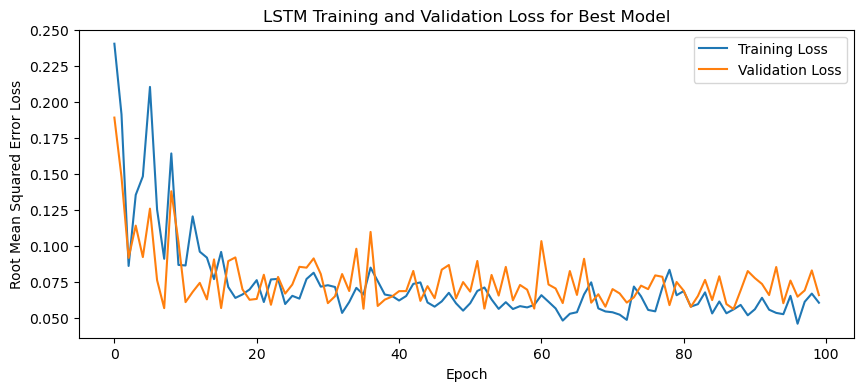

1/1 - 2s - loss: 0.0911 - 2s/epoch - 2s/step
Test Loss: 0.0911443755030632
Fold 2:
Epoch 1/100
19/19 [==============================] - 9s 121ms/step - loss: 0.2375 - val_loss: 0.0484
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1331 - val_loss: 0.2136
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1606 - val_loss: 0.0596
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1623 - val_loss: 0.1017
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1482 - val_loss: 0.0471
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1055 - val_loss: 0.0360
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0698 - val_loss: 0.0611
Epoch 8/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1166 - val_loss: 0.0609
Epoch 9/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0897 - val_loss: 0.0511
Epoch 10/100
19/19 [====

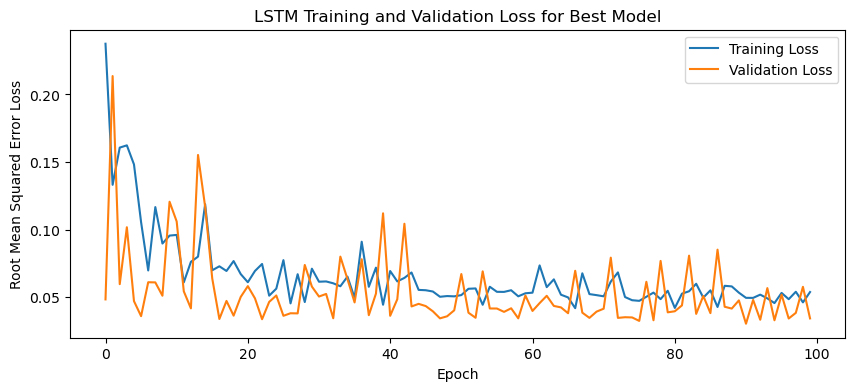

1/1 - 2s - loss: 0.1244 - 2s/epoch - 2s/step
Test Loss: 0.12443233281373978
Fold 3:
Epoch 1/100
19/19 [==============================] - 7s 81ms/step - loss: 0.1866 - val_loss: 0.1510
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.2073 - val_loss: 0.0954
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1080 - val_loss: 0.2105
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0887 - val_loss: 0.1187
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1442 - val_loss: 0.0691
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1219 - val_loss: 0.0829
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1096 - val_loss: 0.1269
Epoch 8/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0807 - val_loss: 0.0697
Epoch 9/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1042 - val_loss: 0.0960
Epoch 10/100
19/19 [====

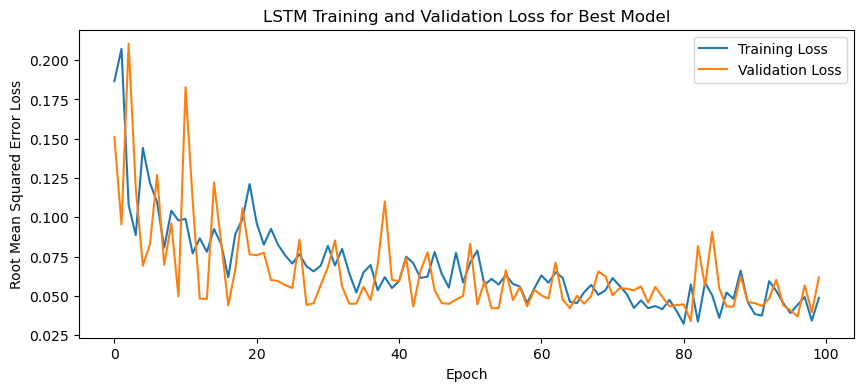

1/1 - 1s - loss: 0.0627 - 1s/epoch - 1s/step
Test Loss: 0.06266267597675323
Fold 4:
Epoch 1/100
20/20 [==============================] - 7s 76ms/step - loss: 0.2680 - val_loss: 0.0449
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1659 - val_loss: 0.0651
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1566 - val_loss: 0.0156
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1284 - val_loss: 0.1213
Epoch 5/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1258 - val_loss: 0.0515
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1081 - val_loss: 0.1233
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1001 - val_loss: 0.2428
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0963 - val_loss: 0.0391
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0993 - val_loss: 0.0335
Epoch 10/100
20/20 [====

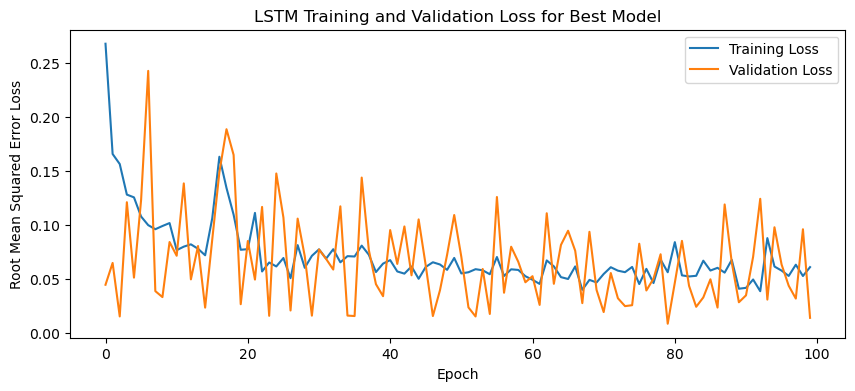

1/1 - 2s - loss: 0.0539 - 2s/epoch - 2s/step
Test Loss: 0.05391759052872658
Fold 5:
Epoch 1/100
19/19 [==============================] - 9s 140ms/step - loss: 0.2713 - val_loss: 0.0347
Epoch 2/100
19/19 [==============================] - 0s 9ms/step - loss: 0.2264 - val_loss: 0.0402
Epoch 3/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1681 - val_loss: 0.0268
Epoch 4/100
19/19 [==============================] - 0s 9ms/step - loss: 0.2103 - val_loss: 0.0413
Epoch 5/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1342 - val_loss: 0.0314
Epoch 6/100
19/19 [==============================] - 0s 10ms/step - loss: 0.0820 - val_loss: 0.0717
Epoch 7/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1688 - val_loss: 0.0998
Epoch 8/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1178 - val_loss: 0.1576
Epoch 9/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1223 - val_loss: 0.1876
Epoch 10/100
19/19 [==

1/1 - 2s - loss: 0.0531 - 2s/epoch - 2s/step
Test Loss: 0.053137291222810745


In [6]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

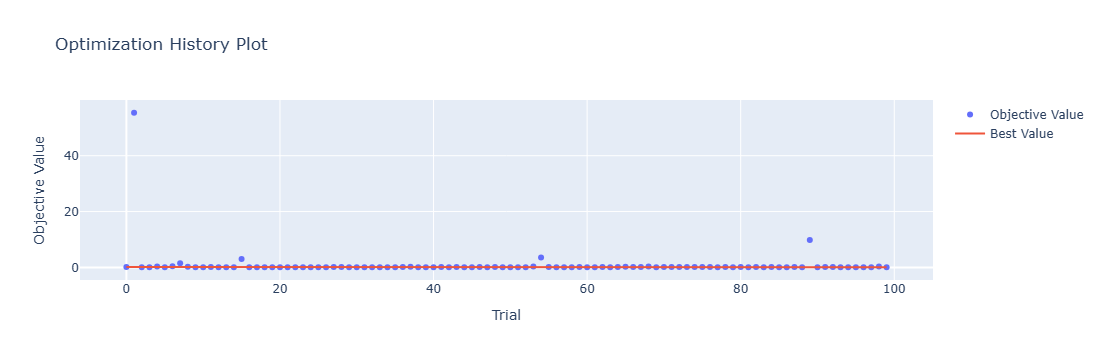

In [7]:
optuna.visualization.plot_optimization_history(study)

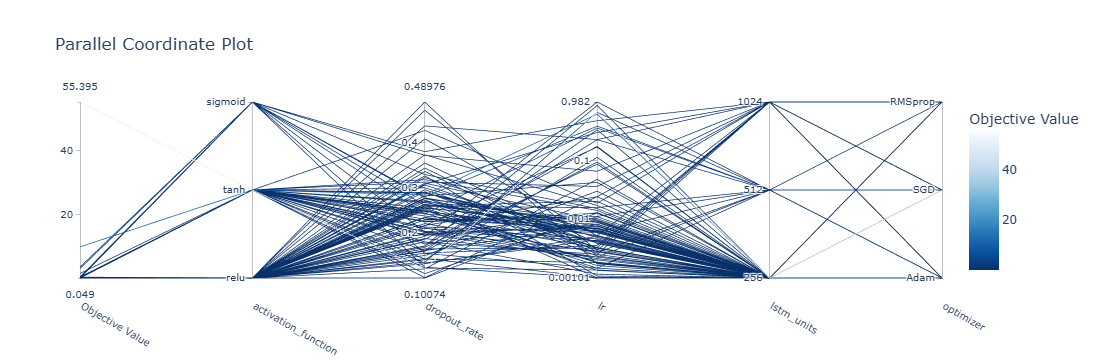

In [8]:
optuna.visualization.plot_parallel_coordinate(study)

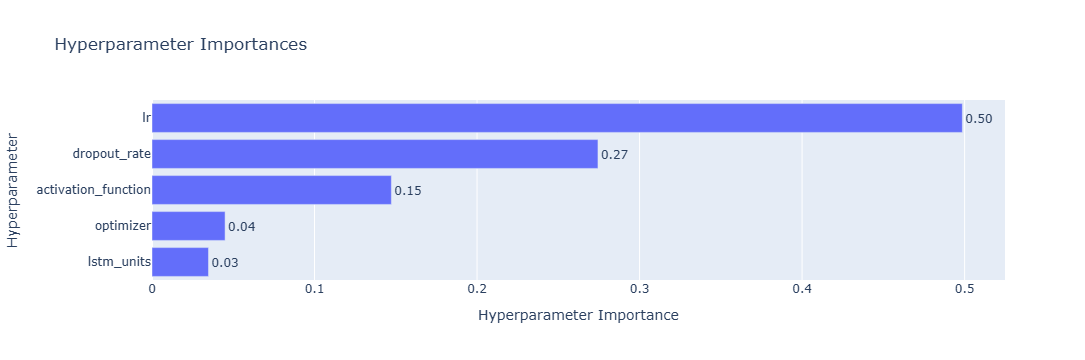

In [9]:
optuna.visualization.plot_param_importances(study)

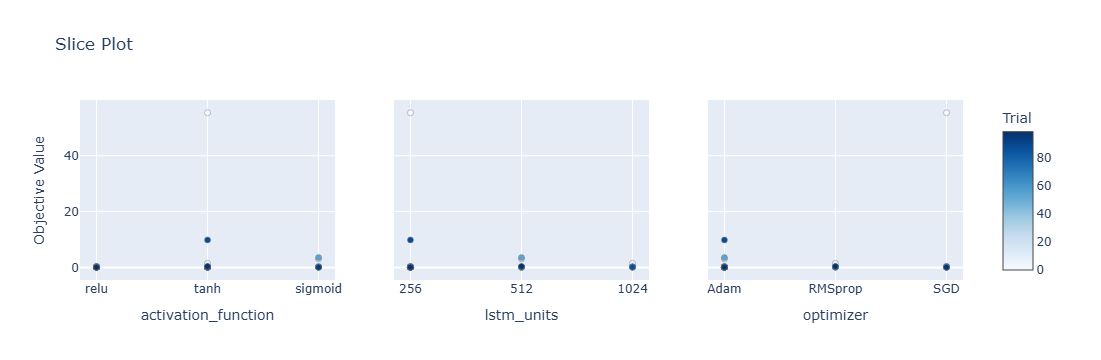

In [10]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

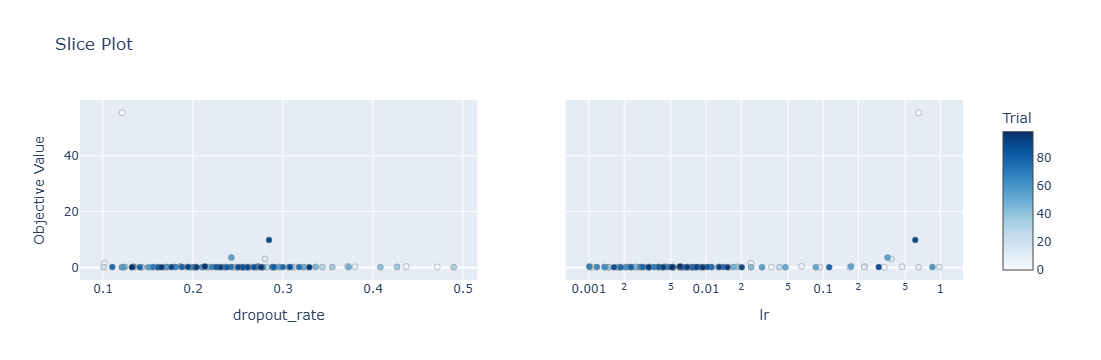

In [11]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 21s 286ms/step - loss: 0.2927 - accuracy: 0.0000e+00 - mae: 0.2927 - rmse: 0.2927 - mape: 53.8202 - pearson: nan - val_loss: 0.3202 - val_accuracy: 0.0000e+00 - val_mae: 0.3202 - val_rmse: 0.3202 - val_mape: 53.6684 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 32ms/step - loss: 0.1648 - accuracy: 0.0000e+00 - mae: 0.1648 - rmse: 0.1648 - mape: 30.2503 - pearson: nan - val_loss: 0.0843 - val_accuracy: 0.0000e+00 - val_mae: 0.0843 - val_rmse: 0.0843 - val_mape: 14.2546 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 43ms/step - loss: 0.1512 - accu

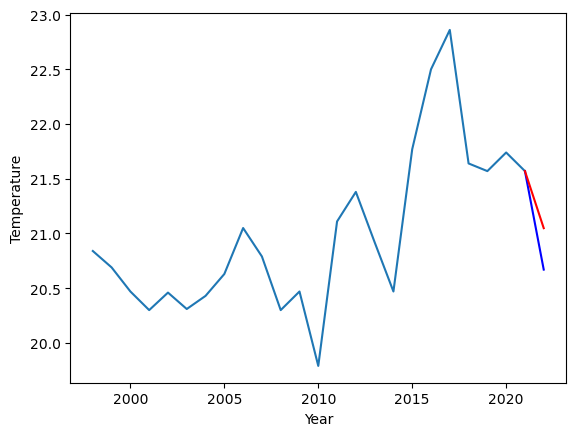

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
16.06		16.72		0.66


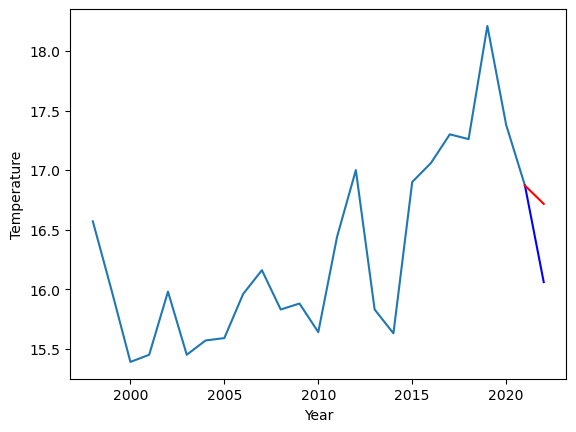

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.67  21.048689
1                1   16.06  16.716715


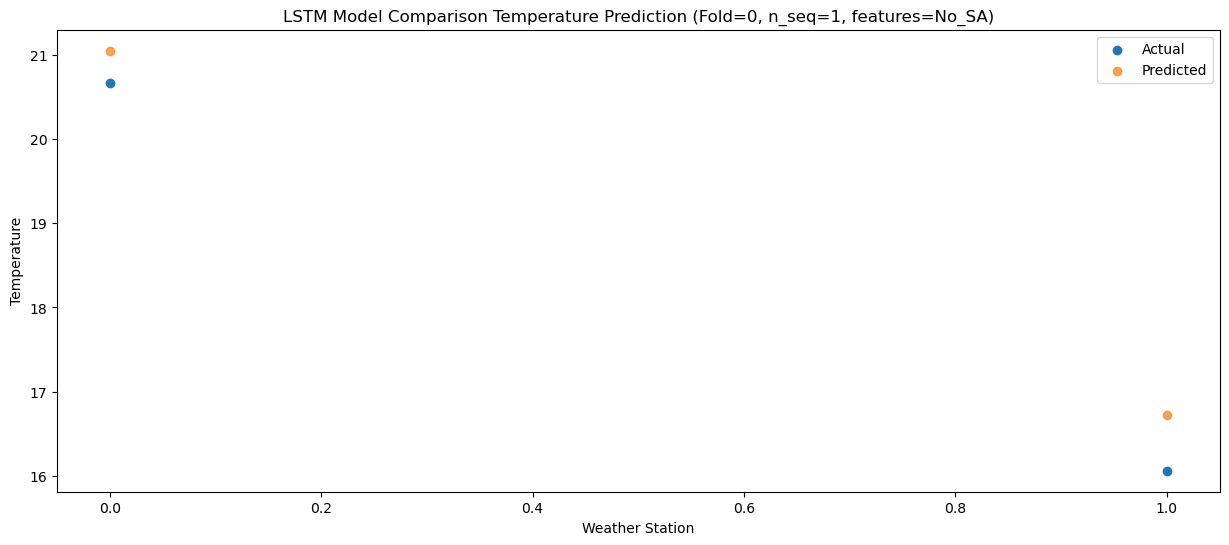

f, t:
[[20.67 16.06]]
[[21.0486895  16.71671549]]
Year at t+1:
t+1 SKRMSE: 0.536041
t+1 KRMSE: 0.536041
t+1 MAE: 0.517702
t+1 SKMAPE: 0.029606
t+1 R2_SCORE: 0.945918
t+1 KMAPE: 0.029606
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.536041
KRMSE: 0.536041
MAE: 0.517702
SKMAPE: 0.029606
R2_SCORE: 0.945918
KMAPE: 0.029606
PEARSON: 1.000000
Model: "sequential_510"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1020 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1020 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1021 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1021 (Dropout)      (1, 256)                  0         
                                  

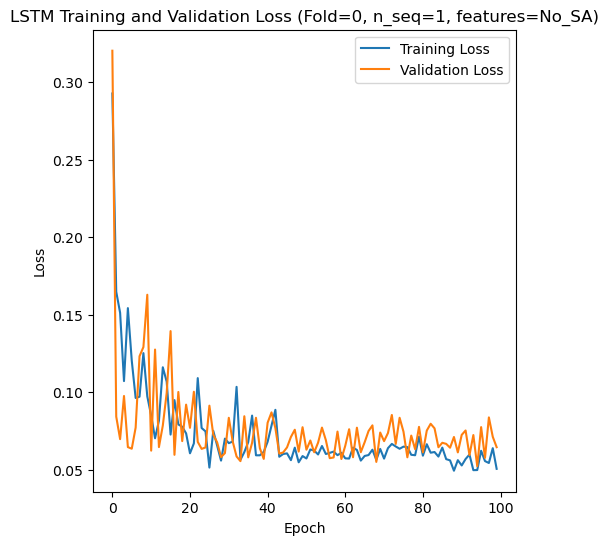

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 26s 380ms/step - loss: 0.3218 - accuracy: 0.0000e+00 - mae: 0.3218 - rmse: 0.3218 - mape: 52.7549 - pearson: nan - val_loss: 0.0935 - val_accuracy: 0.0000e+00 - val_mae: 0.0935 - val_rmse: 0.0935 - val_mape: 14.4521 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 3s 142ms/step - loss: 0.1649 - accuracy: 0.0000e+00 - mae: 0.1649 - rmse: 0.1649 - mape: 27.1713 - pearson: nan - val_loss: 0.0398 - val_accuracy: 0.0000e+00 - val_mae: 0.0398 - val_rmse: 0.0398 - val_mape: 5.7475 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 2s 109ms/step - loss: 0.1446 - accu

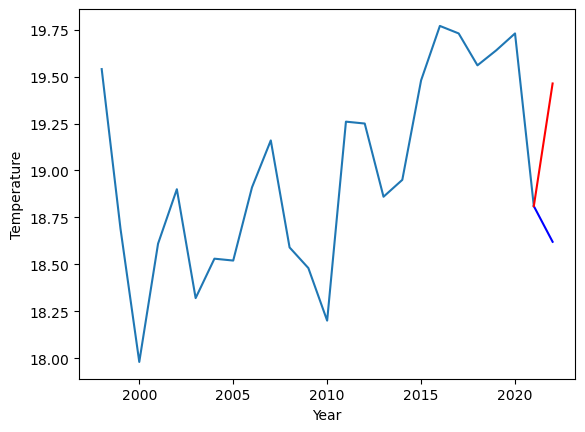

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.30		19.61		0.31


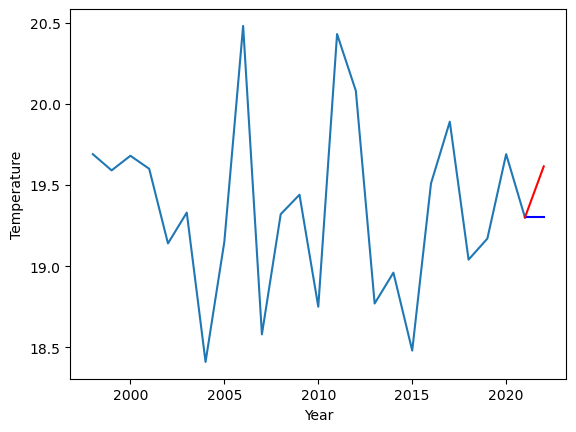

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   18.62  19.463381
1                1   19.30  19.614586


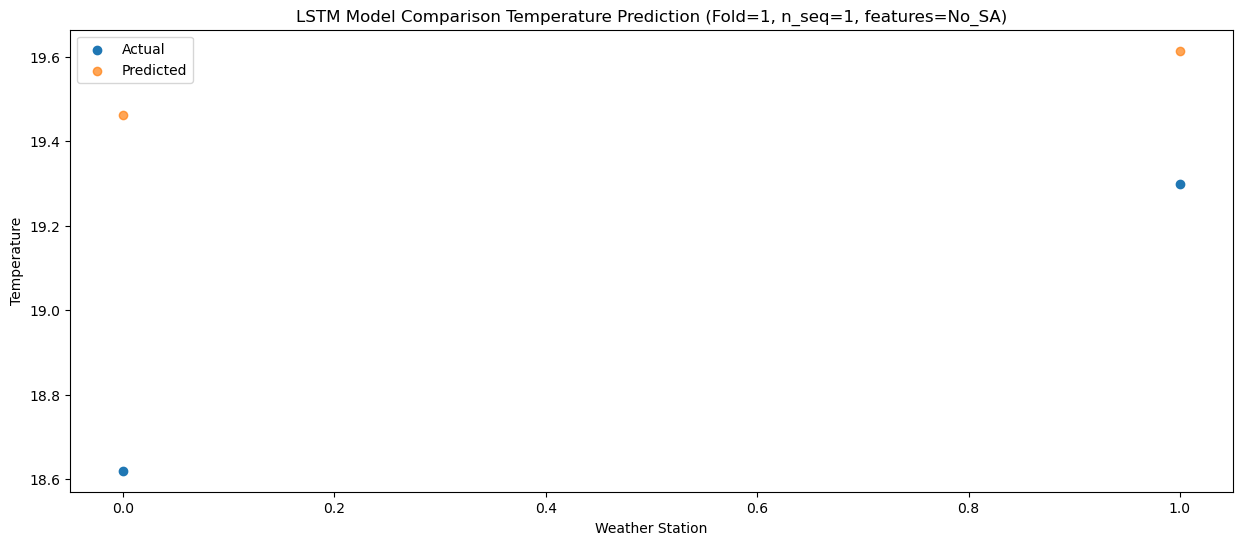

f, t:
[[18.62 19.3 ]]
[[19.46338112 19.61458583]]
Year at t+1:
t+1 SKRMSE: 0.636497
t+1 KRMSE: 0.636497
t+1 MAE: 0.578983
t+1 SKMAPE: 0.030797
t+1 R2_SCORE: -2.504567
t+1 KMAPE: 0.030797
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.636497
KRMSE: 0.636497
MAE: 0.578983
SKMAPE: 0.030797
R2_SCORE: -2.504567
KMAPE: 0.030797
PEARSON: 1.000000
Model: "sequential_511"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1022 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1022 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1023 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1023 (Dropout)      (1, 256)                  0         
                                

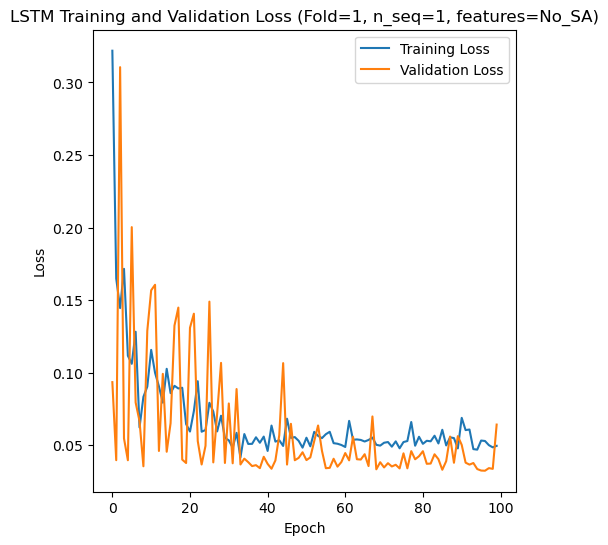

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 19s 300ms/step - loss: 0.3047 - accuracy: 0.0000e+00 - mae: 0.3047 - rmse: 0.3047 - mape: 48.2798 - pearson: nan - val_loss: 0.0716 - val_accuracy: 0.0000e+00 - val_mae: 0.0716 - val_rmse: 0.0716 - val_mape: 12.9257 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 73ms/step - loss: 0.1737 - accuracy: 0.0000e+00 - mae: 0.1737 - rmse: 0.1737 - mape: 27.8802 - pearson: nan - val_loss: 0.1079 - val_accuracy: 0.0000e+00 - val_mae: 0.1079 - val_rmse: 0.1079 - val_mape: 16.8112 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 70ms/step - loss: 0.1616 - accur

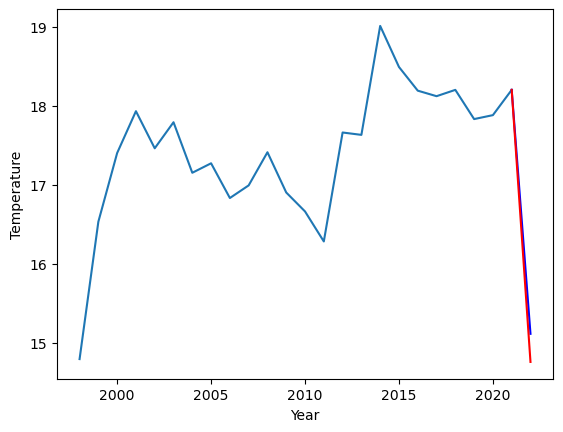

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.86		14.03		0.17


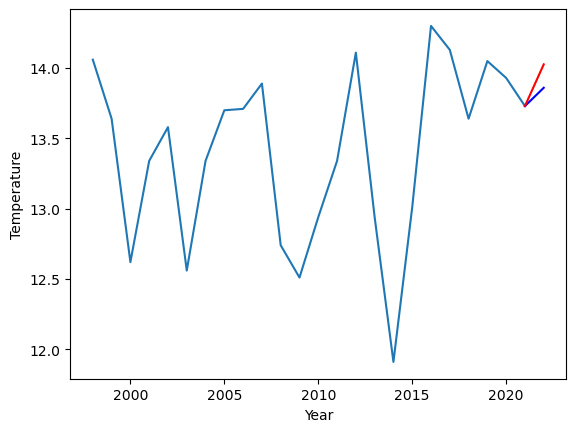

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   15.11  14.754035
1                1   13.86  14.026495


f, t:
[[15.11 13.86]]
[[14.75403538 14.02649481]]
Year at t+1:
t+1 SKRMSE: 0.277877
t+1 KRMSE: 0.277877
t+1 MAE: 0.261230
t+1 SKMAPE: 0.017785
t+1 R2_SCORE: 0.802328
t+1 KMAPE: 0.017785
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.277877
KRMSE: 0.277877
MAE: 0.261230
SKMAPE: 0.017785
R2_SCORE: 0.802328
KMAPE: 0.017785
PEARSON: 1.000000
Model: "sequential_513"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1026 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1026 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1027 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1027 (Dropout)      (1, 256)                  0         
                                  

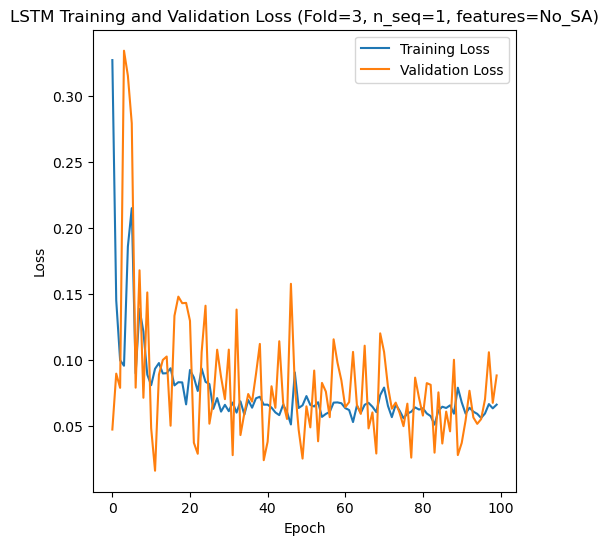

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 26s 515ms/step - loss: 0.3909 - accuracy: 0.0000e+00 - mae: 0.3909 - rmse: 0.3909 - mape: 63.8647 - pearson: nan - val_loss: 0.1571 - val_accuracy: 0.0000e+00 - val_mae: 0.1571 - val_rmse: 0.1571 - val_mape: 23.6559 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 2s 88ms/step - loss: 0.1070 - accuracy: 0.0000e+00 - mae: 0.1070 - rmse: 0.1070 - mape: 17.2957 - pearson: nan - val_loss: 0.0480 - val_accuracy: 0.0000e+00 - val_mae: 0.0480 - val_rmse: 0.0480 - val_mape: 7.5535 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 2s 82ms/step - loss: 0.1217 - accur

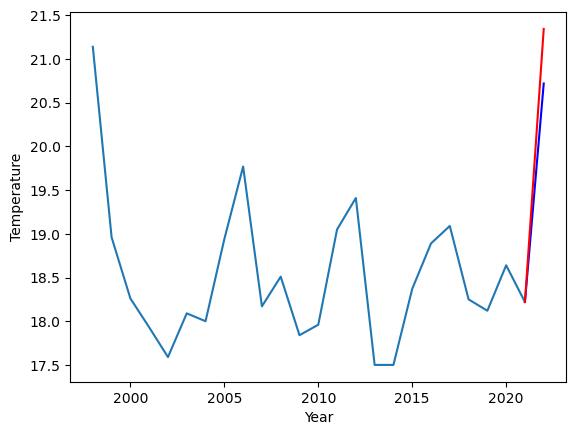

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.25		13.22		-0.03


Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.72  21.344388
1                1   13.25  13.216544


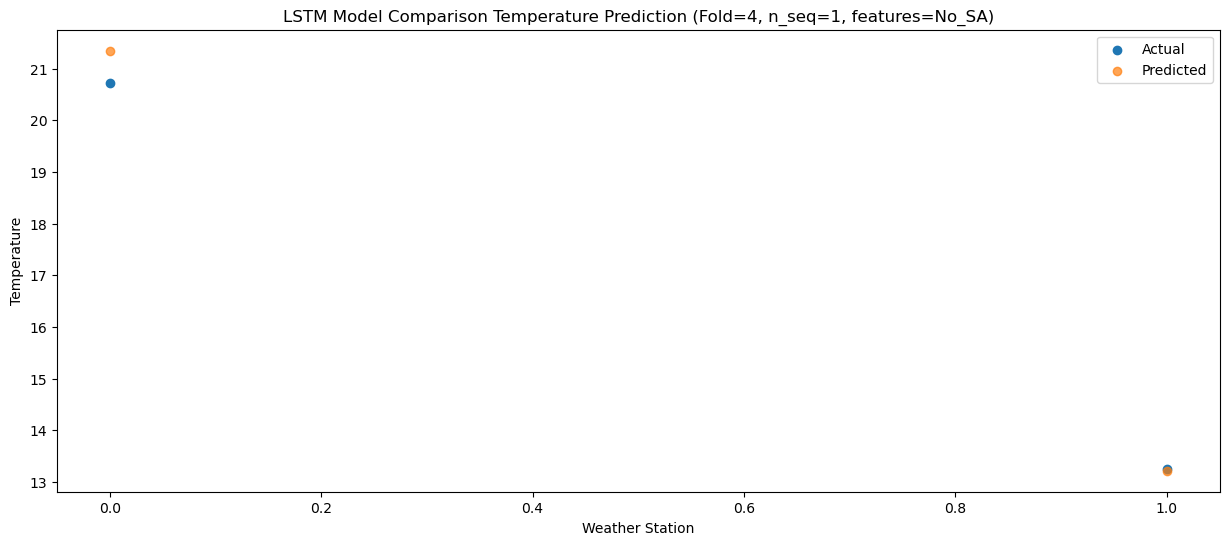

f, t:
[[20.72 13.25]]
[[21.34438752 13.21654426]]
Year at t+1:
t+1 SKRMSE: 0.442142
t+1 KRMSE: 0.442142
t+1 MAE: 0.328922
t+1 SKMAPE: 0.016330
t+1 R2_SCORE: 0.985987
t+1 KMAPE: 0.016330
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.442142
KRMSE: 0.442142
MAE: 0.328922
SKMAPE: 0.016330
R2_SCORE: 0.985987
KMAPE: 0.016330
PEARSON: 1.000000
Model: "sequential_514"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1028 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1028 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1029 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1029 (Dropout)      (1, 256)                  0         
                                  

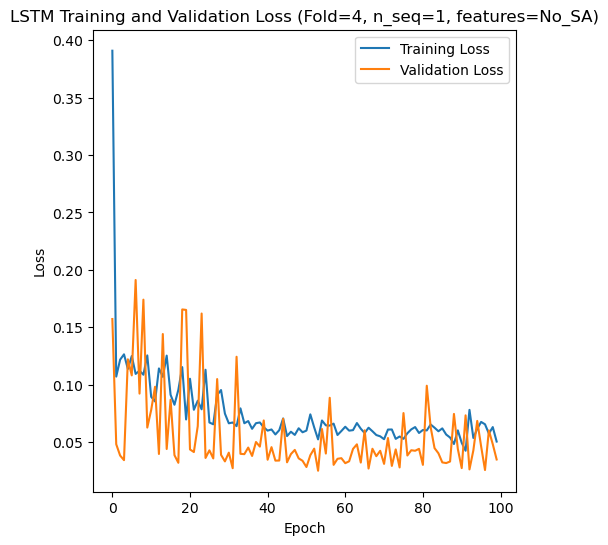

[[0.5360414964193951], [0.6364966459302877], [0.587693385976888], [0.2778770686227496], [0.44214197729914045]]
[[array(0.5360415)], [array(0.63649665)], [array(0.58769339)], [array(0.27787707)], [array(0.44214198)]]
[[0.5177024939656238], [0.5789834770560276], [0.5014265924692145], [0.26122971460223177], [0.3289216262102137]]
[[0.029606052961081576], [0.03079707574887955], [0.030870590231054387], [0.017785413475125807], [0.016329746935328036]]
[[0.9459177237292231], [-2.50456730346455], [0.8922057626413096], [0.8023278969180864], [0.9859866397789288]]
[[array(0.02960605)], [array(0.03079708)], [array(0.03087059)], [array(0.01778541)], [array(0.01632975)]]
[[array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)]]
[[[21.048689495921135], [16.716715492010117]], [[19.463381119966506], [19.614585834145547]], [[16.27205279111862], [13.694905976057052]], [[14.754035384356975], [14.02649481356144]], [[21.34438751578331], [13.216544263362884]]]
[[[20.67], [16.060000000000002]], [[18.619

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.003047148059884415
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 256
    dropout_rate = 0.26876821543893603

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(np.mean(pearson_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S1_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

In [53]:
print(series_ws)

1998    20.84
1999    20.69
2000    20.47
2001    20.30
2002    20.46
2003    20.31
2004    20.43
2005    20.63
2006    21.05
2007    20.79
2008    20.30
2009    20.47
2010    19.79
2011    21.11
2012    21.38
2013    20.92
2014    20.47
2015    21.77
2016    22.50
2017    22.86
2018    21.64
2019    21.57
2020    21.74
2021    21.57
2022    21.81
2023    22.23
2024    22.62
dtype: float64


In [54]:
print(series_ws[:n_lag+2+len(forecasts)].values)

[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
 19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
 21.81 22.23]
